<a href="https://colab.research.google.com/github/tomonari-masada/course-nlp2020/blob/master/11_topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 標準使用ライブラリー
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import gc
import os
import shutil
from icecream import ic
from tqdm import tqdm_notebook as tqdm 

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# 追記
import json
import datetime
import math
plt.style.use('dark_background')

# debug
#%pdb on

import pixiedust #%pixie_debugger

# tfがエラーはかないため
# tfがエラーはかないため
#import tensorflow as tf
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="5"
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)


Pixiedust database opened successfully


In [2]:
import pandas as pd
import re
import emoji

df = pd.read_csv("./result0605.csv", engine='python')

type(df["description"])
docs = df["description"].to_list()

In [3]:
print(len(docs))

93794


In [4]:
print(docs[0][:1000])

漫画、アニメ、声優垢。 RT多め気ままに呟きます。伏線系の漫画好き。古川慎さん・小林裕介さん・河西健吾さん ・田丸篤志さん推し


### Neologdを使ってtokenizeする

In [5]:
docs

['漫画、アニメ、声優垢。 RT多め気ままに呟きます。伏線系の漫画好き。古川慎さん・小林裕介さん・河西健吾さん ・田丸篤志さん推し',
 'D垢。プリンセスよく描いてけど…たまに違うものも描きます。手遅めですがよろしくお願いします🙇🙇 ※名前の読み方は自由なんで好きなように読んでください 最近は低浮上なので…別の絵垢 →@ri_ri_ri_ri_on',
 '𝖒𝖔𝖔𝖓𝖎𝖆𝖓 ♤  𝔣𝔱𝔦𝔰𝔩𝔞𝔫𝔡  ♢ 𝖒𝖎𝖞𝖆𝖛𝖎  ♧  𝔥𝔬𝔦𝔷𝔢𝔯  ♡  𝖇𝖇𝖟  ✩  𝔪𝔢𝔩𝔩𝔬𝔴𝔪𝔬𝔱𝔦𝔣\n˗ˏˋ⋆·˚ ༘ * アララカタブラツルリンコｫォォオ!!✩‧₊˚´ˎ˗.',
 'ENHYPEN、アニメ・漫画 ゲーム関連でTwitter使ってるので、それ以外は無反応です、、',
 '【心にゆとりと潤いを💞】目指すのは学校の保健室のような場所・ホッと一息つける場所｜あなたの幸せを願っています｜職業:音楽の講師｜《自分磨き中》自分らしくあるためのツイート｜思った事を呟きます｜時々ドジ有り｜🐶2匹と🐈4匹がいます🐾',
 '過去にジャパリカート動画、TSUMURI KART(VRChat)など作ったり、ワリスノ(MK8DX)一位だったりした人。\n社会に出てから疲れてる。\n配信→https://t.co/FJoitl8JHE\n\nヘッダの猫の飼い主→@___smmmmm',
 '🔥🎴・💎⚡️・⚡️🎴・👹🎴主の雑多垢🙏 成人20⬆️ic:自作 hd:@kmtmiu_ 様よりフリーヘッダー',
 '18↑ 夢追翔 伏見ガク ガオンくん応援アカウント アークナイツ dbdやってます',
 'スコティッシュ猫アンジェレッタ(2011,06,01生れの女の子）が可愛い過ぎて、毎日猫バカ生活です。\r\n好き☆猫☆動物☆爬虫類☆塊根植物☆藤原竜也☆ﾏﾝｶﾞ・ｱﾆﾒ☆大友克洋☆ＡＫＩＲＡ☆萩尾望都☆せがわまさき☆近藤片岡コンビ☆羽海野チカ☆ベルセルク☆ヒグチユウコ☆リラックマ☆沖縄☆',
 '98line/こもｻﾝ・堀ｻﾝ・健ｻﾝよりall▶LDHall love♡陸ｸﾝよりall↪︎#チームNEXT #ジェネ #ランペ #ファンタ  固定ツイrtいいねお願い ⚠※推し好きな物多め注意報⚠︎ /田中氏よりall▶ #スト #teamSixTONES ▶ #介護福祉',
 '21年毎日更新ブロ

In [6]:
import subprocess
cmd='echo `mecab-config --dicdir`"/mecab-ipadic-neologd"'
path_neologd = (subprocess.Popen(cmd, stdout=subprocess.PIPE,
                           shell=True).communicate()[0]).decode('utf-8')
import MeCab
m=MeCab.Tagger("-Ochasen -d "+str(path_neologd))

# def remove_emoji(string):
#     emoji_pattern = re.compile("["
#                            u"\U0001F600-\U0001F64F"  # emoticons
#                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
#                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
#                            u"\U00002702-\U000027B0"
#                            u"\U000024C2-\U0001F251"
#                            "]+", flags=re.UNICODE)
#     return emoji_pattern.sub(r'', string)

def neolog_prep_text( text):
  return_words = []
  splited_text = (re.split('[\t,]', line) for line in m.parse(text).split('\n'))
  for tmp_word in splited_text :
    if (tmp_word[0] in ('EOS', '', 't', 'ー') ):
       continue 
    if not re.match( '名詞' ,tmp_word[3]  ) or tmp_word[0] in emoji.UNICODE_EMOJI["en"]:
      continue
    else:
      return_words.append(tmp_word[0])
      
#   words = [item[0]
#          for item in items
#          if (item[0] not in ('EOS', '', 't', 'ー') and re.match( '名詞' ,item[3]  ) and item[0] not in emoji.UNICODE_EMOJI["en"]
#               )]
  return return_words

* tokenizationの実行

In [7]:
from tqdm import tqdm

new_docs = list()
for doc in tqdm(docs):
  if str(doc) == "nan":
    continue
  tmp_words =  neolog_prep_text(str(doc))
  new_docs.append( tmp_words )
  

100%|██████████| 93794/93794 [00:23<00:00, 3921.13it/s]


* tokenizationの結果を確認

In [8]:
print(new_docs[5])

['過去', 'ジャパリカート', '動画', 'TSUMURI', 'KART', 'VRChat', 'ワリスノ', 'MK', '8', 'DX', '一位', 'りし', 'た人', '社会', '出て', '配信', 'https', 'co', 'FJoitl', '8', 'JHE', 'ヘッダ', '猫', '飼い主', 'smmmmm']


* 各文書を長い文字列で表しなおす（CountVectorizerを後で使うため）

In [9]:
corpus = [' '.join(doc) for doc in new_docs]

In [10]:
new_docs

[['漫画',
  'アニメ',
  '声優',
  '垢',
  'RT',
  '多め',
  '気まま',
  '伏線',
  '系',
  '漫画',
  '好き',
  '古川慎',
  'さん',
  '小林裕介',
  'さん',
  '河西健吾',
  'さん',
  '田丸篤志',
  'さん'],
 ['D',
  '垢',
  'プリンセス',
  'たま',
  'もの',
  '手遅',
  'め',
  'よろしくお願いします',
  '名前',
  '読み方',
  '自由',
  '好き',
  'よう',
  '最近',
  '浮上',
  '別',
  '絵',
  '垢',
  'ri',
  'ri',
  'ri',
  'ri',
  'on'],
 ['アララカタブラツルリンコｫォォオ', '₊'],
 ['ENHYPEN', 'アニメ', '漫画', 'ゲーム', '関連', 'Twitter', 'それ', '以外', '反応'],
 ['心',
  'ゆとり',
  '潤い',
  'の',
  '学校',
  '保健室',
  'よう',
  '場所',
  '一息',
  '場所',
  'あなた',
  '幸せ',
  '職業',
  '音楽',
  '講師',
  '自分磨き',
  '中',
  '自分',
  'ため',
  'ツイート',
  '事',
  'ドジ',
  '有り',
  '2',
  '匹',
  '4',
  '匹'],
 ['過去',
  'ジャパリカート',
  '動画',
  'TSUMURI',
  'KART',
  'VRChat',
  'ワリスノ',
  'MK',
  '8',
  'DX',
  '一位',
  'りし',
  'た人',
  '社会',
  '出て',
  '配信',
  'https',
  'co',
  'FJoitl',
  '8',
  'JHE',
  'ヘッダ',
  '猫',
  '飼い主',
  'smmmmm'],
 ['主', '雑多', '垢', '成人', '20', 'ic', '自作', 'hd', 'kmtmiu', '様', 'フリーヘッダー'],
 ['18', '夢追翔', '伏見', 'ガク', 'ガオン

## 11-02 データ行列の作成
* NMFの場合、TF-IDFで単語の重みを求めて各文書をベクトル化する。
* LDAの場合、単に単語の出現頻度を重みとして各文書をベクトル化する。

### sklearnのCountVectorizerで疎行列化する

* 全文書の半分より多い文書に現れる単語は、高頻度語とみなして削除する。
* 10件未満の文書にしか現れない単語は、低頻度語とみなして削除する。

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_df=0.5, min_df=10, stop_words='english')
X = vectorizer.fit_transform(corpus)

In [12]:
print(X[0])

  (0, 11011)	2
  (0, 4596)	1
  (0, 8932)	1
  (0, 2601)	1
  (0, 8967)	1
  (0, 10801)	1
  (0, 9173)	1
  (0, 8628)	1
  (0, 3800)	4
  (0, 9434)	1


In [13]:
print(vectorizer.get_feature_names())

['00', '000', '001', '007', '009', '01', '0101', '011', '0120', '0129', '016', '02', '020', '021', '0221', '03', '04', '05', '0501', '06', '0626', '07', '08', '09', '090', '092', '0g', '0m', '0t', '0v', '0w', '0時', '0歳', '10', '100', '1000', '10000', '1000万', '1000人', '100パーセント', '100万', '100万円', '100人', '100円', '100均', '100年', '100本', '101', '1010', '1013', '1014', '1016', '1026', '104', '105', '106', '107', '108', '109', '10t', '10万', '10万円', '10代', '10分', '10周年', '10回', '10年', '10年目', '10時', '10月', '10歳', '11', '110', '1100', '1102', '1106', '1111', '1115', '112', '1120', '1123', '1127', '113', '114', '114514', '115', '119', '11回', '11年', '11年目', '11時', '11月', '11歳', '12', '120', '1200', '1203', '1205', '1208', '1220', '1224', '1226', '123', '1234', '124', '125', '127', '129', '12年', '12年目', '12時', '12月', '12歳', '13', '130', '1300', '139', '13年', '13年目', '13時', '13歳', '14', '140', '147', '148', '14年', '14年目', '14歳', '15', '150', '1500', '151', '157', '15年', '15年目', '15時', '15歳', '16

In [14]:
print(len(vectorizer.get_feature_names()))

13333


* 文書数と語彙サイズを変数にセット

In [15]:
X.shape

(88481, 13333)

In [16]:
n_samples, n_features = X.shape

### TF-IDFで各文書における単語の重みを計算する

In [17]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer()
Xtfidf = tfidf.fit_transform(X)

In [18]:
print(Xtfidf[0])

  (0, 11011)	0.36136896605162344
  (0, 10801)	0.2816687518007433
  (0, 9434)	0.42939921559866673
  (0, 9173)	0.11056311585240382
  (0, 8967)	0.1999865605689152
  (0, 8932)	0.21436519651612368
  (0, 8628)	0.39733182759512364
  (0, 4596)	0.14390644902737101
  (0, 3800)	0.5473814284224066
  (0, 2601)	0.1712079388666493


In [19]:
Xtfidf.shape

(88481, 13333)

* 抽出するトピックの個数は、今回は20個とする。

In [20]:
n_components = 20

## 11-03 NMFでトピック抽出
* まず、TF-IDFのデータ行列を使って　NMFによってトピック抽出を試みる。
 * NMFのパラメータ群は下記サンプルコードのまま。
 * https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

### NMFとLDAのインポート

In [21]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

### NMFによるトピック抽出の実行

In [22]:
from time import time

print((f"Fitting the NMF model (generalized Kullback-Leibler "
  f"divergence) with tf-idf features, n_samples={n_samples} "
  f"and n_features={n_features}"))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1, l1_ratio=.5,
          verbose=1)
nmf.fit(Xtfidf)
print(f"done in {time() - t0:0.3f}s.")

Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=88481 and n_features=13333
Epoch 10 reached after 4.469 seconds, error: 1597.010961
Epoch 20 reached after 8.720 seconds, error: 1593.582836
Epoch 30 reached after 12.966 seconds, error: 1592.663734
Epoch 40 reached after 17.204 seconds, error: 1592.246481
Epoch 50 reached after 21.455 seconds, error: 1591.997937
Epoch 60 reached after 25.735 seconds, error: 1591.830478
done in 27.440s.


* NMFにおける各コンポーネントは、それぞれのトピックにおける単語の重要度を表すベクトルとして表現されている。

In [23]:
nmf.components_

array([[4.60826916e-11, 0.00000000e+00, 0.00000000e+00, ...,
        2.98246168e-13, 1.19394012e-03, 0.00000000e+00],
       [3.51996792e-03, 6.80634179e-03, 5.46431041e-03, ...,
        1.63349532e-02, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 6.35976836e-03, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 6.72892400e-03, 1.69235104e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

### トピックの重要語を取り出す関数の定義

In [24]:
def get_top_words(model, feature_names, n_top_words=30):
  top_features = list()
  weights = list()
  for topic_idx, topic in enumerate(model.components_):
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    top_features.append([feature_names[i] for i in top_features_ind])
    weights.append(topic[top_features_ind])
  return top_features, weights

### NMFの各コンポーネントから重要語を取り出す

In [25]:
top_words, weights = get_top_words(nmf, vectorizer.get_feature_names())

In [26]:
"nan" in vectorizer.get_feature_names()

False

In [27]:
print(top_words[0])

['好き', 'アニメ', 'フォロー', 'あと', '漫画', '特撮', '女子', '男子', '作品', '動物', '気軽', 'ねこ', 'ただ', 'ヲタ', '一番', '写真', 'マンガ', '基本', '無言', 'キャラ', '鉄道', '変態', 'オタク', '好きな物', 'モノ', 'タイプ', 'ガンダム', '全般', '仮面ライダー', '先生']


In [28]:
topic_words = [dict(zip(top_words[i], weights[i])) for i in range(n_components)]

In [29]:
topic_words[0]

{'好き': 6.296653138806034,
 'アニメ': 0.717536087173088,
 'フォロー': 0.551163706174144,
 'あと': 0.4202951048738906,
 '漫画': 0.4087706070724431,
 '特撮': 0.3857691999376163,
 '女子': 0.2811606754097754,
 '男子': 0.27398553741816983,
 '作品': 0.2662144509332632,
 '動物': 0.25924448437278447,
 '気軽': 0.24050410449041573,
 'ねこ': 0.23233618189005126,
 'ただ': 0.22244321916518764,
 'ヲタ': 0.22219973989662112,
 '一番': 0.19704867126041828,
 '写真': 0.19646056105921417,
 'マンガ': 0.19398223440395473,
 '基本': 0.1909815062694016,
 '無言': 0.1909294426365401,
 'キャラ': 0.19055896107515777,
 '鉄道': 0.1888987371622557,
 '変態': 0.16435676248405387,
 'オタク': 0.15786001306973538,
 '好きな物': 0.1575517698162352,
 'モノ': 0.15679729338071652,
 'タイプ': 0.15613913609162453,
 'ガンダム': 0.1545006402191852,
 '全般': 0.15323078968695258,
 '仮面ライダー': 0.14920205521503513,
 '先生': 0.14754280397569527}

### 重要語をワードクラウドで可視化

In [30]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS

* ワードクラウドから除去するストップワードを確認する。

In [31]:
print(STOPWORDS)

{"i'll", "mustn't", 'r', "doesn't", 'after', 'once', 'those', 'so', 'all', 'how', 'against', 'but', 'from', "let's", 'on', "she'll", 'each', 'where', 'who', 'few', 'it', 'off', "weren't", "isn't", 'otherwise', 'for', 'of', 'my', 'cannot', 'had', "how's", 'if', 'shall', 'then', 'you', 'their', "couldn't", "i'd", 'his', 'can', "they'll", 'below', 'than', "you'll", 'doing', 'himself', 'too', 'whom', 'again', "they're", 'other', 'them', "won't", "don't", 'does', 'also', 'our', "that's", 'herself', 'before', 'hence', "it's", "we'd", "where's", 'as', 'ought', "didn't", 'at', "you'd", 'same', 'did', 'ourselves', "she'd", 'and', "what's", "shouldn't", 'myself', 'www', 'yours', 'during', 'do', 'is', 'him', 'or', 'else', 'here', 'http', "aren't", 'having', 'not', "she's", 'the', 'i', 'theirs', 'through', "wouldn't", 'like', 'k', 'itself', 'we', 'have', 'been', 'he', 'out', 'both', 'since', 'she', "you're", "haven't", 'were', 'down', 'a', "he'll", 'be', "why's", 'such', "hadn't", 'with', 'to', 'a

* ワードクラウドを描画

In [32]:
FONT_PATH = "/usr/share/fonts/opentype/ipaexfont-mincho/ipaexm.ttf"
cloud = WordCloud(stopwords=STOPWORDS,
                  font_path=FONT_PATH,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=100,
                  colormap='tab10'
                  )

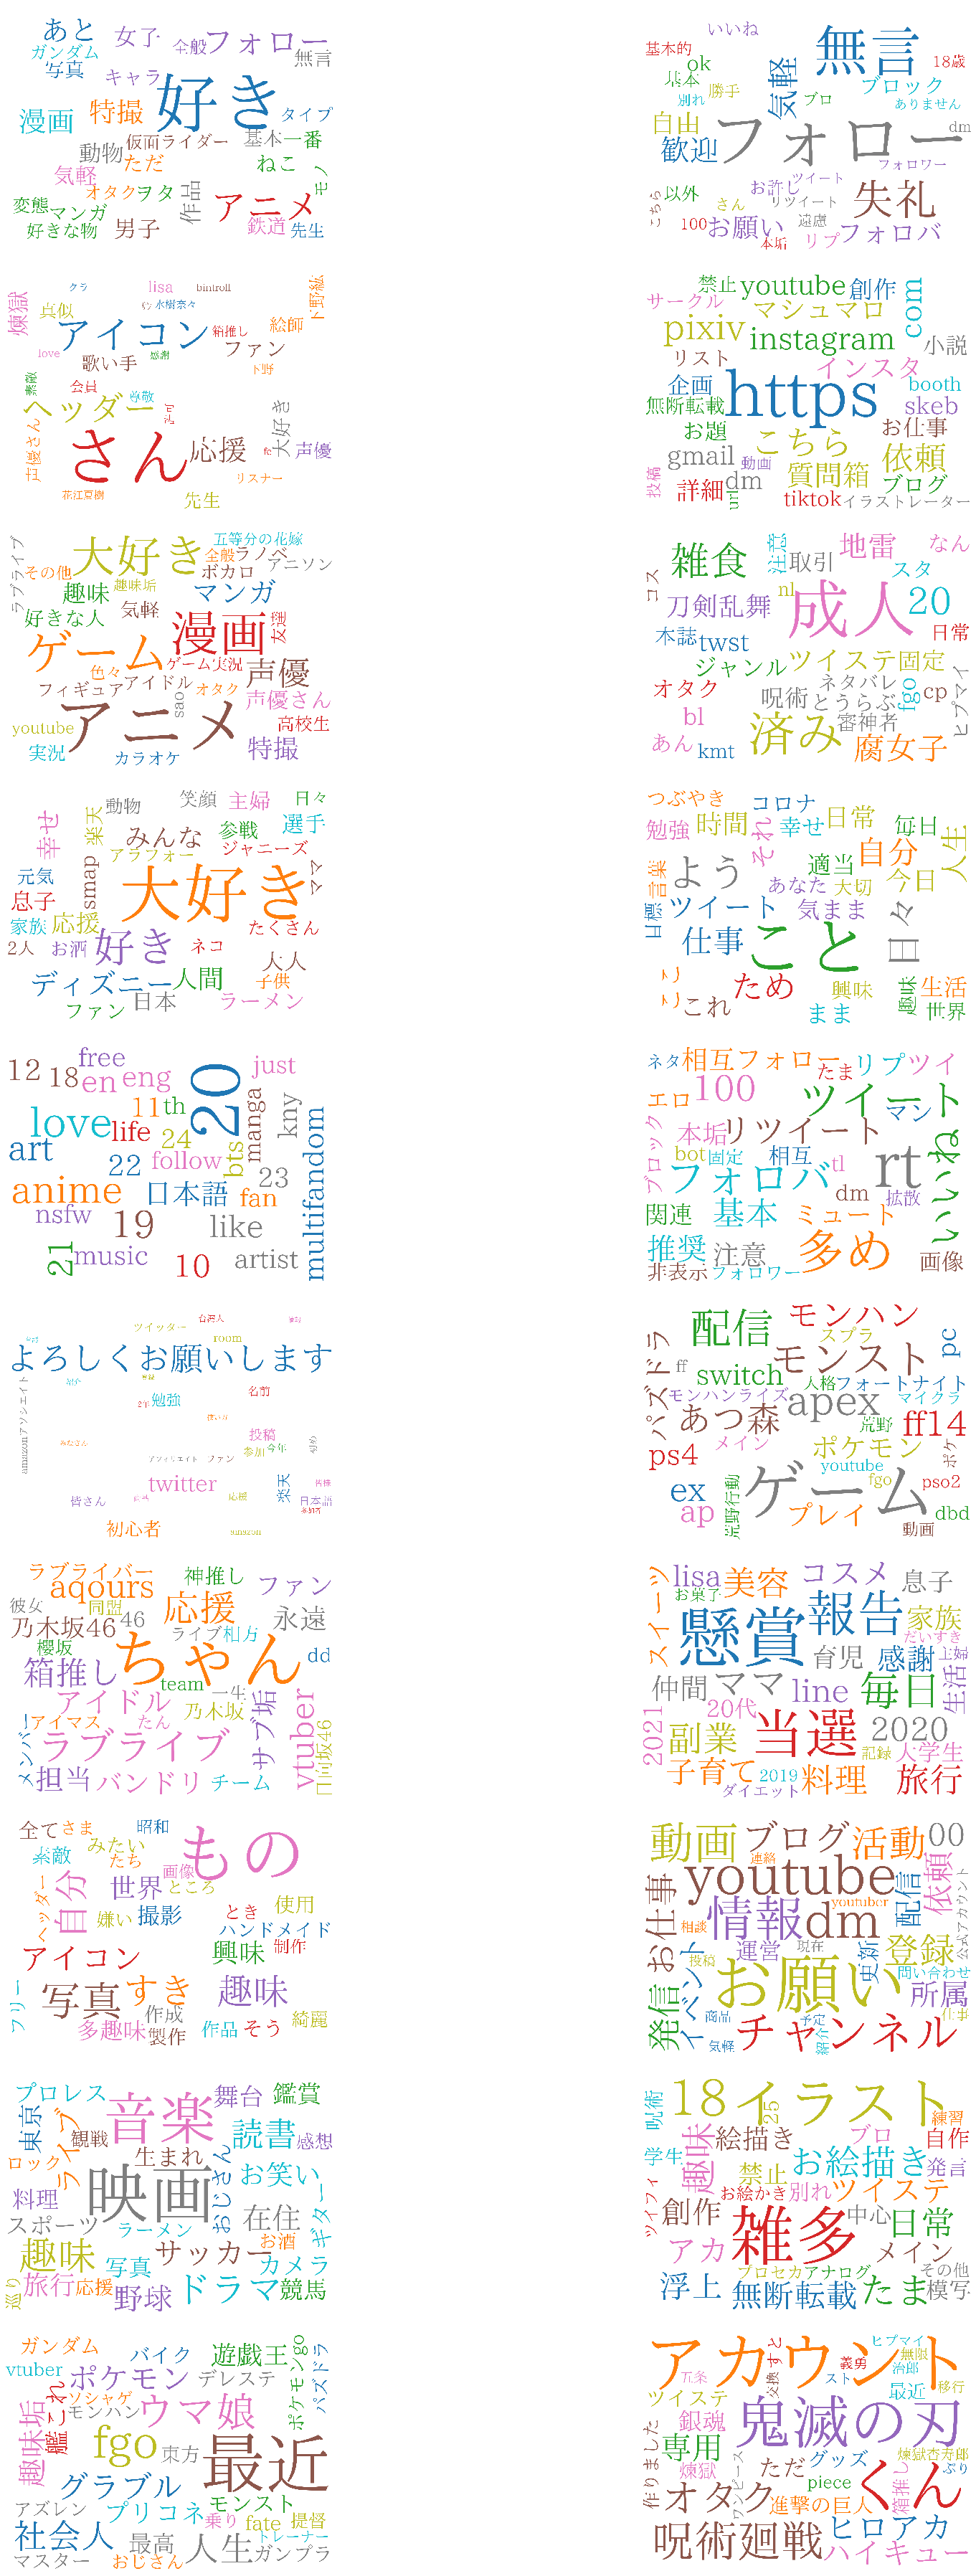

In [33]:
fig, axes = plt.subplots(10, 2, figsize=(32, 50), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
  fig.add_subplot(ax)
  cloud.generate_from_frequencies(topic_words[i], max_font_size=500)
  plt.gca().imshow(cloud)
  plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
  plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()

## 11-04 LDAでトピック抽出

### LDAによるトピック抽出の実行

In [34]:
lda = LatentDirichletAllocation(n_components=n_components, 
                                max_iter=20,
                                topic_word_prior=0.01,
                                learning_method='online',
                                learning_offset=50,
                                batch_size=200,
                                mean_change_tol=1e-4,
                                random_state=1,
                                evaluate_every=1,
                                verbose=1)

In [35]:
print((f"Fitting LDA models with tf features, "
  f"n_samples={n_samples} and n_features={n_features}"))
t0 = time()
lda.fit(X)
print(f"done in {time() - t0:0.3f}s.")

Fitting LDA models with tf features, n_samples=88481 and n_features=13333
iteration: 1 of max_iter: 20, perplexity: 8248.0544
iteration: 2 of max_iter: 20, perplexity: 8073.3711
iteration: 3 of max_iter: 20, perplexity: 8023.1648
iteration: 4 of max_iter: 20, perplexity: 8002.4449
iteration: 5 of max_iter: 20, perplexity: 7989.2099
iteration: 6 of max_iter: 20, perplexity: 7978.1297
iteration: 7 of max_iter: 20, perplexity: 7973.4384
iteration: 8 of max_iter: 20, perplexity: 7969.9735
iteration: 9 of max_iter: 20, perplexity: 7967.8054
iteration: 10 of max_iter: 20, perplexity: 7962.7570
iteration: 11 of max_iter: 20, perplexity: 7957.8072
iteration: 12 of max_iter: 20, perplexity: 7955.3208
iteration: 13 of max_iter: 20, perplexity: 7954.6469
iteration: 14 of max_iter: 20, perplexity: 7953.9813
iteration: 15 of max_iter: 20, perplexity: 7954.3793
iteration: 16 of max_iter: 20, perplexity: 7954.5000
iteration: 17 of max_iter: 20, perplexity: 7954.3488
iteration: 18 of max_iter: 20, per

### LDAの各トピックから高確率語を取り出す

In [36]:
top_words, weights = get_top_words(lda, vectorizer.get_feature_names())

In [37]:
print(top_words[0])

['こと', '好き', '世界', 'なん', '大好き', 'ただ', '11', '19', '全般', '応援', '募集中', '趣味', 'これ', '多趣味', 'お酒', '東方', 'ナナ', 'pc', '最近', '料理', '俳優', 'ジャニーズ', '出身', 'プロレス', 'pop', 'スマホ', '所属', '友達', '尊敬', '大学生']


In [38]:
topic_words = [dict(zip(top_words[i], weights[i])) for i in range(n_components)]

### 高確率語をワードクラウドで可視化

In [39]:
cloud = WordCloud(stopwords=STOPWORDS,
                                font_path=FONT_PATH,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=100,
                  colormap='tab10'
                  )

In [ ]:
import datetime
(datetime.datetime.now() + datetime.timedelta(hours=9) ) .strftime('%m%d_%H%M')

'0606_2044'

In [ ]:
# fig, axes = plt.subplots(5, 4, figsize=(16, 25), sharex=True, sharey=True)
fig, axes = plt.subplots(7, 3, figsize=(32, 50), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    
  if i > len(topic_words)-1:
    break

  fig.add_subplot(ax)
  cloud.generate_from_frequencies(topic_words[i], max_font_size=500)
  plt.gca().imshow(cloud)
  plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
  plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()


from matplotlib.backends.backend_pdf import PdfPages

import datetime
pdf = PdfPages( 
(datetime.datetime.now() + datetime.timedelta(hours=9) ) .strftime('%m%d_%H%M') + 'topic.pdf')


fignums = plt.get_fignums()
for fignum in fignums:
    plt.figure(fignum)
    pdf.savefig()

pdf.close()

In [ ]:
import pyLDAvis
import pyLDAvis.sklearn

In [ ]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, X, vectorizer, mds='tsne')
panel